In [1]:
import random
import helpers
import numpy as np
import pandas as pd
from copy import copy
from genetic import Experiment,Population,Chromosome,Gen
from joblib import Parallel, delayed,parallel_backend
import time
from ExperimentBaseNuggets import ExperimentBaseModel
import matplotlib.pyplot as plt
import math
import gdal

In [13]:
class Experiment1(ExperimentBaseModel):
    def __init__(self,data,name,path,target,verbose):
        ExperimentBaseModel.__init__(self,data,name,path,target,verbose)
        self.mem = {}
    
    def setupChromosome(self,chromosome,goal):
        keys = list(self.domain.keys())
        keys = sorted(keys)
        for key in keys:
            if len(self.domain[key]) > 10:
                noChoices = random.randint(1,10)
            else:
                noChoices = random.randint(1,len(self.domain[key])//2)
            vals = set(random.choices(self.domain[key],k=noChoices))
            chromosome.genes.append(Gen(key,vals))
    
    def mutate(self,chromosome):
        if random.random() < self.mutationRate:
            index = random.randint(0,len(chromosome.genes)-1)
            identifier = chromosome.genes[index].identifier
            proportion =  len(self.domain[identifier]) - len(chromosome.genes[index].value)
            if proportion < random.random():
                val = random.choice(self.domain[identifier])
                chromosome.genes[index].value.add(val)
            else:
                if len(chromosome.genes[index].value) > 0:
                    el = random.choice(list(chromosome.genes[index].value))
                    chromosome.genes[index].value.remove(el)
    
    def crossover(self,parent1,parent2,population):
        setup = lambda x: self.setupChromosome(x,population.goal)
        crossover = lambda p1,p2: self.crossover(p1,p2,population)
        chromosome1 = Chromosome(setup,self.express,crossover,self.mutate,population.generation)
        chromosome2 = Chromosome(setup,self.express,crossover,self.mutate,population.generation)
        chromosome1.parents = [parent1,parent2]
        chromosome2.parents = [parent1,parent2]
        iGenes = list(range(len(parent1.genes)))#list(self.domain.keys())
        random.shuffle(iGenes)
        mid = len(iGenes)//2
        genes1 = [Gen(parent1.genes[x].identifier,copy(parent1.genes[x].value)) for x in iGenes[:mid]]
        genes1 += [Gen(parent2.genes[x].identifier,copy(parent2.genes[x].value)) for x in iGenes[mid:]]
        chromosome1.genes = sorted(genes1,key=lambda x: x.identifier)
        genes2 = [Gen(parent2.genes[x].identifier,copy(parent2.genes[x].value)) for x in iGenes[:mid]]
        genes2 += [Gen(parent1.genes[x].identifier,copy(parent1.genes[x].value)) for x in iGenes[mid:]]
        chromosome2.genes = sorted(genes2,key=lambda x: x.identifier)
        return [chromosome1,chromosome2]
    
    def express(self,chromosome):
        rule = "lambda summary2,goal: ["
        pos = []
        neg = []
        posMatch = []
        negMatch = []
        notZero = 0
        for gen in chromosome.genes:
            temp2 = []
            temp3 = []
            isZero = True
            for val in gen.value:
                if val != -1:
                    isZero=False
                    temp = f"summary2[{gen.identifier}][{val}][goal] if goal in summary2[{gen.identifier}][{val}] else set()"
                    temp2.append(temp)
                    for goal in self.goals:
                        if goal != -1:
                            temp3.append(f"summary2[{gen.identifier}][{val}][{goal}] if goal != {goal} and {goal} in summary2[{gen.identifier}][{val}] else set()")
            notZero += 1 if not isZero else 0
            pos.append(f"set([]).union(*[{','.join(temp2)}])")
            neg.append(f"set([]).union(*[{','.join(temp3)}])")
        rule += f"[{','.join(pos)}],[{','.join(neg)}],{notZero if notZero > 0 else 100000}"+"]"
        return rule
    
    def getTotalMatch(self,phenotype,goal):
        totalNeg = 0
        totalPos = 0
        matchProportion = eval(phenotype)
        totalPosMatch,totalNegMatch,noChromosomes = matchProportion(self.summarized2,goal)
        countPosMatch = 0
        for row in totalPosMatch:
            for col in row:
                countPosMatch += self.matrix[col][1]
        countPosMatch = countPosMatch / noChromosomes
        countNegMatch = 0
        for row in totalNegMatch:
            for col in row:
                countNegMatch += self.matrix[col][1]
        countNegMatch = countNegMatch / noChromosomes
        totalPos = self.summarized["total"][goal]
        totalNeg = self.summarized["total"]["total"]-self.summarized["total"][goal]
        totalExamples = totalNeg+totalPos
        posProp = (totalPos/totalExamples) 
        negProp = (totalNeg/totalExamples) 
        total = (countPosMatch * negProp) + (-1*countNegMatch * posProp)
        maxTotal = (totalPos * negProp)
        res = total/maxTotal
        return res
    
    def regulation(self,population):
        population.chromosomes = sorted(population.chromosomes,key = lambda x:x.fitness,reverse = True)
        mid = self.noChromosomes // 2
        indexes = [x for x in range(1,len(population.chromosomes))]
        random.shuffle(indexes)
        indexes = indexes[:self.noChromosomes]
        firstHalf = indexes[:mid]
        secondHalf = indexes[mid:]
        selected = [population.chromosomes[0]]
        selected += (np.array(population.chromosomes)[firstHalf]).tolist()
        selected += (np.array(population.chromosomes)[secondHalf]).tolist()
        population.chromosomes = selected
    
    def setup(self):
        self.radious = 1
        self.neighborhood = helpers.moore([self.radious,self.radious])
        self.mutationRate = .5
        self.noChromosomes = 30
        self.noIterations = 200
        super().setup()

In [3]:
def readraster(file):
    dataSource = gdal.Open(file)
    band = dataSource.GetRasterBand(1)
    band = band.ReadAsArray()
    return(dataSource, band)

In [4]:
stateFiles1 = ["cbddist.tif","roaddist.tif","dda_2021_government_restricted.tif","den1991.tif","slope.tif","Actual_1994.tif"]
stateFiles2 = ["cbddist.tif","roaddist.tif","dda_2021_government_restricted.tif","den2001.tif","slope.tif","Actual_1999.tif"]
stateFiles = [stateFiles1,stateFiles2]
states = []
path = "data"
for i,files in enumerate(stateFiles):
    state = []
    for file in files:
        source,band = readraster(f"{path}/{file}")
        state.append(band)
    states.append(state)

newStates = []
for state in states:
    temp = np.array(state)
    temp = temp.transpose().reshape(-1,np.shape(temp)[0])
    newStates.append(temp)

In [14]:
exp2 = Experiment1(newStates[0],"ExperimentGA","ExperimentGA",5,verbose=2)
exp2.run()

start setup
149.55042219161987
(6786, 3)
150.06242203712463
150.17942452430725
150.2114233970642
5 goals
end setup
config saved at ExperimentGA/24_01_20_00_04_09/config.json
iteration 1
goal = 0
goal = 4goal = 2
goal = 1

goal 0 elapsed time: 0.6389901638031006goal 4 elapsed time: 0.6169929504394531
goal = 3

goal 2 elapsed time: 0.6719918251037598
goal 1 elapsed time: 0.7079873085021973
goal 3 elapsed time: 0.26199889183044434
{'generation': 1, 'elapsedTime': 0.9719901084899902, 'fitness': {0: [0.04450126743153566, 0.15964048016521054, 0.6763001548116383], 4: [0.0683280292620651, -0.26801242416515153, 0.42640327098866687], 2: [0.03916064520682688, -0.2399680915845584, 0.2855678534797989], 1: [0.033987363451487014, -0.024051185271644213, 0.3996186442784978], 3: [0.0765124777497989, 0.2604117780313937, 0.2701524267220588]}}
iteration 2
goal = 0goal = 4
goal = 2
goal = 1

goal 2 elapsed time: 0.13699722290039062
goal 4 elapsed time: 0.1809978485107422
goal = 3
goal 1 elapsed time: 0.1979

In [26]:
exp2.world.populations[3].toDict()

{'generation': 199,
 'goal': '1',
 'chromosomes': [{'uuid': '547ca9c8-df1f-405c-b615-2fbff3225efe',
   'generation': 81,
   'genes': [{'identifier': '0', 'value': '{10000, 5000}'},
    {'identifier': '1', 'value': '{4000, 2500, 500, 3000, 1000}'},
    {'identifier': '2', 'value': '{0}'},
    {'identifier': '3', 'value': 'set()'},
    {'identifier': '4', 'value': '{1, 2, 5, 6, 21, 28}'}],
   'fitness': '0.567352246814943',
   'parents': ['31c1c4e3-6c3a-4dd7-8a2c-8e2ecd2973bd',
    '1e2b302c-57f3-4b78-8ce0-c0dc13732758']},
  {'uuid': 'd54384ca-bda7-4819-9d3e-02e3aebf36f9',
   'generation': 193,
   'genes': [{'identifier': '0', 'value': '{10000, 5000}'},
    {'identifier': '1', 'value': '{4000, 2500, 500, 3000, 1000}'},
    {'identifier': '2', 'value': 'set()'},
    {'identifier': '3', 'value': 'set()'},
    {'identifier': '4', 'value': '{1, 2, 5, 6, 21, 28}'}],
   'fitness': '0.532308123169565',
   'parents': ['942f9745-b92b-40c5-b0b3-3b5433bd2f03',
    '4d811a4c-9d72-4e61-a7cb-ddc2afa57

In [21]:
source,band = readraster(f"{path}/{stateFiles1[1]}")

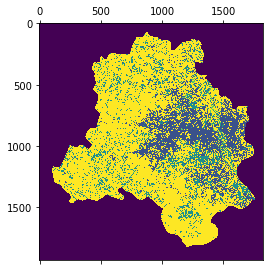

In [22]:
plt.matshow(band)

In [28]:
import helpers
helpers.moore([1,1])

[array([-1, -1]),
 array([-1,  0]),
 array([-1,  1]),
 array([ 0, -1]),
 array([0, 0]),
 array([0, 1]),
 array([ 1, -1]),
 array([1, 0]),
 array([1, 1])]

In [31]:
np.sum([[1,1],[2,2]],axis=0)

array([3, 3])

In [47]:
np.array([[[1,1],[3,3]],[[1,1],[2,2]]])[:][1,1]

array([2, 2])

In [35]:
[1]+list((3,2))

[1, 3, 2]